# Cash Flow Projection Model for Term Life Insurance Portfolio

This notebook creates a cash flow projection model for a portfolio of term life insurance policies for individuals aged 30 to 50. It uses mortality data from the U.S. Social Security Administration (https://www.ssa.gov/oact/HistEst/PerLifeTables/2023/PerLifeTables2023.html) and allows for adjustments to Expected Mortality Rates and Average Life Expectancy.


## Portfolio Creation

The `create_portfolio` function generates a simulated portfolio of life insurance policies. Here's how it works:

1. **Age Distribution**: 
   - We create a range of ages from `MIN_AGE` to `MAX_AGE`.
   - For each age in this range, we generate `NUM_POLICIES_PER_AGE` number of policies.
   - This results in a total of `NUM_POLICIES_PER_AGE * (MAX_AGE - MIN_AGE + 1)` policies.

2. **Gender Assignment**:
   - Each policy is randomly assigned either 'Male' or 'Female' gender with equal probability.

3. **Policy Amount**:
   - Policy amounts are generated using a normal distribution.
   - The mean of this distribution is `AVERAGE_POLICY_AMOUNT`.
   - The standard deviation is set to 20% of the average amount, allowing for some variation in policy sizes.

4. **Result**:
   - The function returns a DataFrame where each row represents a policy.
   - Each policy has an Age, Gender, and PolicyAmount.

## Cash Flow Calculation

The `calculate_cash_flows` function simulates the cash flows for the entire portfolio over the policy term. Here's the process:

1. **Policy-by-Policy Simulation**:
   - For each policy in the portfolio:
     - We start at the policyholder's current age.
     - We simulate year by year until the end of the policy term or until the maximum age in our mortality data is reached.

2. **Annual Calculations**:
   - For each year of each policy:
     1. **Death Probability**: 
        - We look up the death probability for the current age and gender from our mortality data.
        - This probability is adjusted by the `mortality_adjustment` factor.
     2. **Survival Probability**:
        - Calculated as 1 minus the death probability.
     3. **Premium**:
        - Calculated as: `Policy Amount × Annual Premium Rate × Survival Probability`
        - This reflects that premiums are only paid if the policyholder survives the year.
     4. **Claim**:
        - Calculated as: `Policy Amount × Death Probability`
        - This represents the expected payout if the policyholder dies that year.
     5. **Net Cash Flow**:
        - Calculated as: `Premium - Claim`
        - This is the net financial impact for the insurance company for this policy in this year.

3. **Aggregation**:
   - After simulating all policies for all years, we sum up the Premiums, Claims, and Net Cash Flows for each year.
   - This gives us the total cash flow for the entire portfolio for each year of the policy term.

4. **Result**:
   - The function returns a DataFrame with columns for **Year**, **Premium**, **Claim**, and **NetCashFlow**.
   - Each row represents the aggregate cash flows for all policies in a given year.

This simulation allows us to estimate the overall financial performance of the insurance portfolio over time, taking into account the age and gender distribution of the policyholders and the mortality rates from our data.


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load definitions for the Life Tables

In [ ]:
import unstructured_client
from unstructured_client.models import operations, shared

# Initialize the client with your API key and server URL
client = unstructured_client.UnstructuredClient(
    api_key_auth="nViZLo98OrMa80e4FKJ1MVA6U5RBuY",
    server_url="https://api.unstructuredapp.io",
)

# Path to your PDF file
filename = "LifeTableDefinitions.pdf"

# Open the PDF and read its content
with open(filename, "rb") as f:
    data = f.read()

# Create the request to parse the PDF
req = operations.PartitionRequest(
    partition_parameters=shared.PartitionParameters(
        files=shared.Files(
            content=data,
            file_name=filename,
        ),
        strategy=shared.Strategy.HI_RES,  # Use 'hi_res' strategy
        languages=['eng'],  # Specify English as the language
    ),
)

# Make the API call to parse the document
try:
    res = client.general.partition(request=req)
    # Print the first element of the parsed document for verification
    for element in res.elements:
        print(element)
except Exception as e:
    print(f"Error: {e}")





## Define Model Parameters

In [9]:
# Model parameters
MIN_AGE = 30
MAX_AGE = 50
POLICY_TERM = 20  # years
NUM_POLICIES_PER_AGE = 1000 # Number of policies per age group
AVERAGE_POLICY_AMOUNT = 250000 # $250,000
ANNUAL_PREMIUM_RATE = 0.005  # 0.5% of policy amount
INTEREST_RATE = 0.03  # 3% annual interest rate
PROJECTION_YEAR = 2023  # The year for which we're making projections


# Adjustable parameters
MORTALITY_ADJUSTMENT = 1.0  # 1.0 means no adjustment
LIFE_EXPECTANCY_ADJUSTMENT = 0  # 0 means no adjustment

## Load Mortality Data

In [ ]:
def load_mortality_data(year, is_historic=False):
    file_type = "Hist" if is_historic else "Alt2"
    male_file = f"PerLifeTables_M_{file_type}_TR{year}.csv"
    female_file = f"PerLifeTables_F_{file_type}_TR{year}.csv"
    
    # Read the files
    male_data = pd.read_csv(male_file)
    female_data = pd.read_csv(female_file)
    
    # Define column mapping
    column_mapping = {
        'x': 'Age',
        'q(x)': 'Death_Prob',
        'l(x)': 'Num_Surviving',
        'd(x)': 'Num_Deaths',
        'L(x)': 'Person_Years_Lived',
        'T(x)': 'Person_Years_Lived_After',
        'e(x)': 'Life_Expectancy',
        'D(x)': 'D',
        'M(x)': 'M',
        'A(x)': 'A',
        'N(x)': 'N',
        'a(x)': 'a',
        '12a(x)': 'a12'
    }
    
    # Rename columns
    male_data = male_data.rename(columns=column_mapping)
    female_data = female_data.rename(columns=column_mapping)
    
    # Add gender prefix to columns
    male_columns = ['Male_' + col if col not in ['Year', 'Age'] else col for col in male_data.columns]
    female_columns = ['Female_' + col if col not in ['Year', 'Age'] else col for col in female_data.columns]
    
    male_data.columns = male_columns
    female_data.columns = female_columns
    
    # Merge male and female data
    mortality_data = pd.merge(male_data, female_data, on=['Year', 'Age'])
    
    # Filter for the specified projection year
    mortality_data = mortality_data[mortality_data['Year'] == year]
    
    # Set Age as index
    mortality_data = mortality_data.set_index('Age')
    
    return mortality_data

# Load mortality data
mortality_data = load_mortality_data(PROJECTION_YEAR)
print(mortality_data.head())

## Create Portfolio and Calculate Cash Flows

In [28]:
def create_portfolio(num_policies, min_age, max_age):
    ages = np.random.randint(min_age, max_age + 1, num_policies)
    genders = np.random.choice(['Male', 'Female'], num_policies)
    policy_amounts = np.random.normal(AVERAGE_POLICY_AMOUNT, AVERAGE_POLICY_AMOUNT * 0.2, num_policies)
    return pd.DataFrame({'Age': ages, 'Gender': genders, 'PolicyAmount': policy_amounts})

def calculate_cash_flows(portfolio, mortality_data, policy_term, mortality_adjustment, life_expectancy_adjustment):
    cash_flows = []
    
    for _, policy in portfolio.iterrows():
        age = policy['Age']
        gender = policy['Gender']
        policy_amount = policy['PolicyAmount']
        
        for year in range(policy_term):
            current_age = age + year
            if current_age > mortality_data.index.max():
                break
            death_prob = mortality_data.loc[current_age, f'{gender}_Death_Prob'] * mortality_adjustment
            survival_prob = 1 - death_prob
            
            premium = policy_amount * ANNUAL_PREMIUM_RATE * survival_prob
            claim = policy_amount * death_prob
            
            cash_flows.append({
                'Year': year + 1,
                'Premium': premium,
                'Claim': claim,
                'NetCashFlow': premium - claim
            })
    
    return pd.DataFrame(cash_flows).groupby('Year').sum().reset_index()

# Create portfolio and calculate cash flows
portfolio = create_portfolio(NUM_POLICIES_PER_AGE * (MAX_AGE - MIN_AGE + 1), MIN_AGE, MAX_AGE)
cash_flows = calculate_cash_flows(portfolio, mortality_data, POLICY_TERM, MORTALITY_ADJUSTMENT, LIFE_EXPECTANCY_ADJUSTMENT)

# Convert cash flows to natural numbers
cash_flows = cash_flows.round(0).astype(int)

# Provide an explanation for each column
explanation = """
The table below represents the cash flow projections for the insurance portfolio over the policy term. 
Each row corresponds to a specific year and includes the following columns:
- Year: The year of the policy term.
- Premium: The total premium collected for the year.
- Claim: The total claim paid out for the year.
- NetCashFlow: The net cash flow for the year (Premium - Claim).
- CumulativeNetCashFlow: The cumulative net cash flow up to the current year.
"""

print(explanation)
print(cash_flows.to_string(index=False))


The table below represents the cash flow projections for the insurance portfolio over the policy term. 
Each row corresponds to a specific year and includes the following columns:
- Year: The year of the policy term.
- Premium: The total premium collected for the year.
- Claim: The total claim paid out for the year.
- NetCashFlow: The net cash flow for the year (Premium - Claim).
- CumulativeNetCashFlow: The cumulative net cash flow up to the current year.

 Year  Premium    Claim  NetCashFlow
    1 26207209 12049001     14158208
    2 26203639 12763030     13440609
    3 26199631 13564697     12634934
    4 26195125 14465792     11729333
    5 26190061 15478768     10711293
    6 26184387 16613555      9570831
    7 26178073 17876340      8301733
    8 26171100 19270916      6900184
    9 26163450 20800920      5362529
   10 26155082 22474483      3680599
   11 26145940 24302975      1842965
   12 26135976 26295639      -159663
   13 26125186 28453781     -2328595
   14 26113596 3077

## Visualize Cash Flows

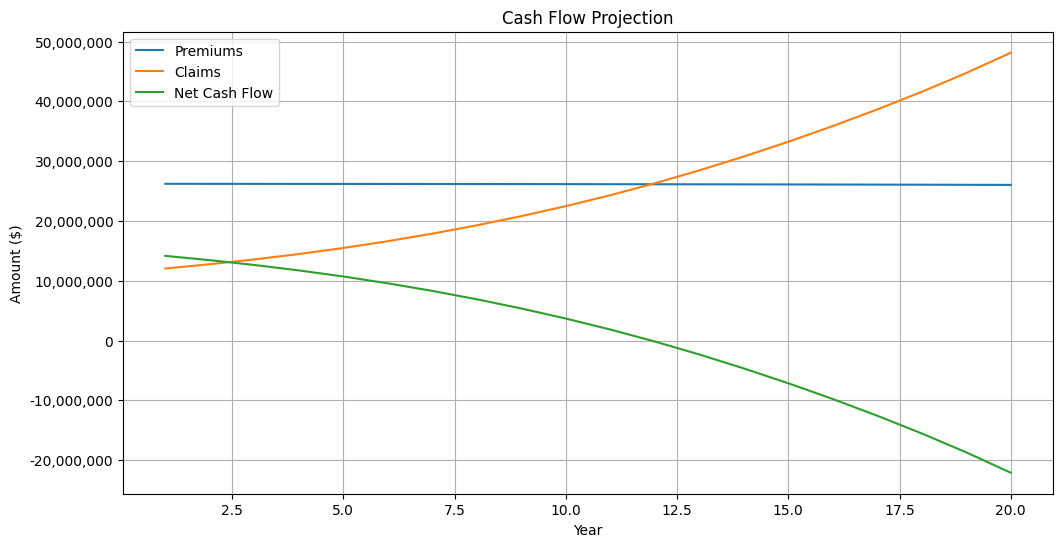

The graph above shows the cash flow projection over the policy term. The 'Premiums' line represents the total premiums collected each year, the 'Claims' line represents the total claims paid out each year, and the 'Net Cash Flow' line represents the difference between premiums collected and claims paid out each year.


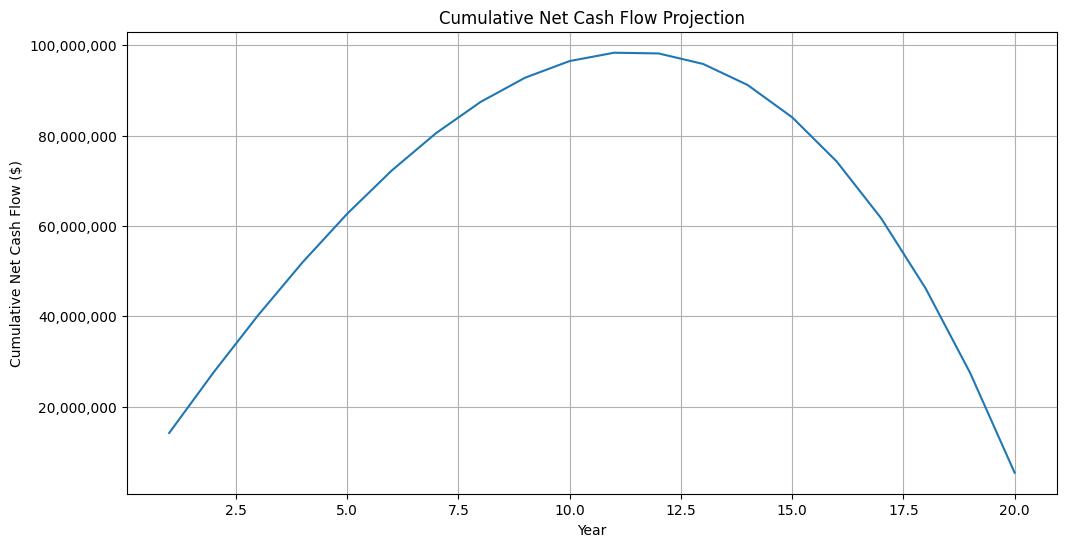

The graph above shows the cumulative net cash flow projection over the policy term. The 'Cumulative Net Cash Flow' line represents the total net cash flow accumulated up to each year.


In [30]:
plt.figure(figsize=(12, 6))
plt.plot(cash_flows['Year'], cash_flows['Premium'], label='Premiums')
plt.plot(cash_flows['Year'], cash_flows['Claim'], label='Claims')
plt.plot(cash_flows['Year'], cash_flows['NetCashFlow'], label='Net Cash Flow')
plt.xlabel('Year')
plt.ylabel('Amount ($)')
plt.title('Cash Flow Projection')
plt.legend()
plt.grid(True)
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.show()

# Explanation of the graph
print("The graph above shows the cash flow projection over the policy term. The 'Premiums' line represents the total premiums collected each year, the 'Claims' line represents the total claims paid out each year, and the 'Net Cash Flow' line represents the difference between premiums collected and claims paid out each year.")

# Cumulative cash flow
cash_flows['CumulativeNetCashFlow'] = cash_flows['NetCashFlow'].cumsum()

plt.figure(figsize=(12, 6))
plt.plot(cash_flows['Year'], cash_flows['CumulativeNetCashFlow'])
plt.xlabel('Year')
plt.ylabel('Cumulative Net Cash Flow ($)')
plt.title('Cumulative Net Cash Flow Projection')
plt.grid(True)
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.show()

# Explanation of the graph
print("The graph above shows the cumulative net cash flow projection over the policy term. The 'Cumulative Net Cash Flow' line represents the total net cash flow accumulated up to each year.")

## Sensitivity Analysis



## How the Sensitivity Analysis Works

1. **Input Parameters**:
   - `portfolio`: The simulated insurance portfolio
   - `mortality_data`: The baseline mortality data
   - `policy_term`: The duration of the policies
   - `parameter`: The parameter we're analyzing (either 'mortality' or 'life_expectancy')
   - `values`: A range of values for the chosen parameter

2. **Process**:
   - For each value in the specified range:
     a. If analyzing mortality:
        - Adjust the mortality rates by multiplying them with the current value
     b. If analyzing life expectancy:
        - Shift the mortality data by adding the current value to the age index
   - Calculate cash flows using the adjusted data
   - Sum up the net cash flows across all years
   - Store the result (parameter value and total net cash flow)

3. **Output**:
   - A DataFrame containing the parameter values and corresponding total net cash flows

## Mortality Rate Sensitivity Analysis

This analysis examines how changes in mortality rates affect the total net cash flow.

1. **Parameter Range**: 
   - Mortality rates are adjusted from 80% to 120% of the baseline rates (0.8 to 1.2, in steps of 0.05)

2. **Interpretation of the Graph**:
   - X-axis: Mortality Rate Adjustment (e.g., 1.0 is baseline, 1.1 is 10% higher mortality)
   - Y-axis: Total Net Cash Flow ($)
   - The line shows how the total net cash flow changes as mortality rates are adjusted
   - A downward slope indicates that higher mortality rates lead to lower net cash flows (more claims paid out)
   - An upward slope would indicate that higher mortality rates lead to higher net cash flows (potentially due to policy terminations)

## Life Expectancy Sensitivity Analysis

This analysis examines how changes in life expectancy affect the total net cash flow.

1. **Parameter Range**: 
   - Life expectancy is adjusted from -5 years to +5 years in 1-year increments

2. **Interpretation of the Graph**:
   - X-axis: Life Expectancy Adjustment (in years)
   - Y-axis: Total Net Cash Flow ($)
   - The line shows how the total net cash flow changes as life expectancy is adjusted
   - An upward slope indicates that increased life expectancy leads to higher net cash flows (fewer claims paid out)
   - A downward slope would indicate that increased life expectancy leads to lower net cash flows (potentially due to longer-term policy payouts)

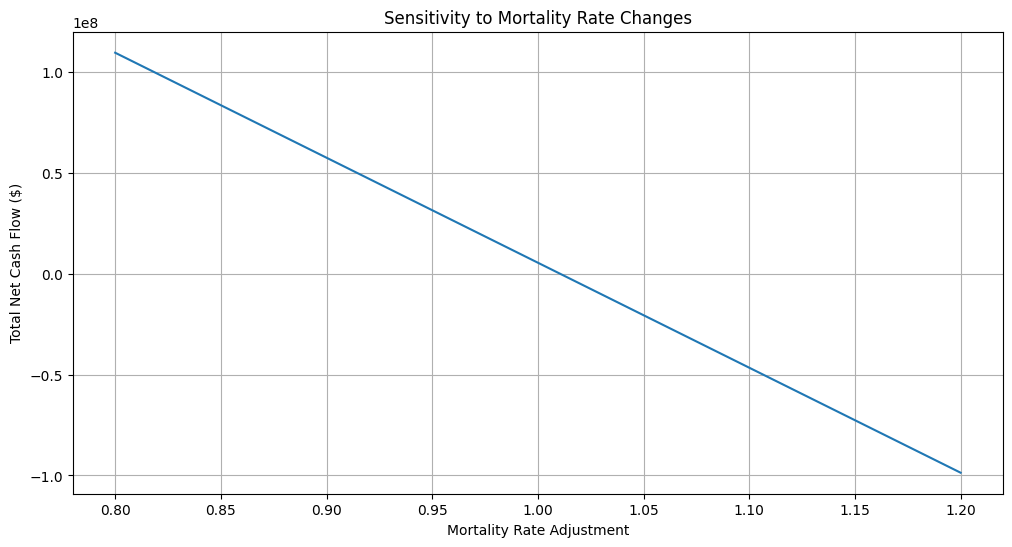

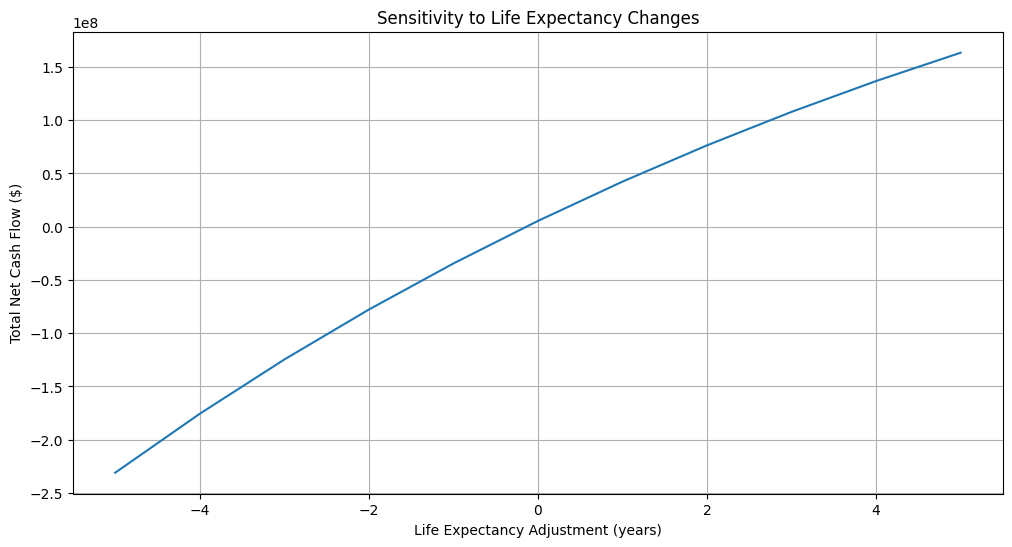

In [31]:
def run_sensitivity_analysis(portfolio, mortality_data, policy_term, parameter, values):
    results = []
    
    for value in values:
        if parameter == 'mortality':
            cash_flows = calculate_cash_flows(portfolio, mortality_data, policy_term, value, 0)
        elif parameter == 'life_expectancy':
            # For life expectancy adjustment, we need to shift the mortality data
            shifted_mortality_data = mortality_data.copy()
            shifted_mortality_data.index = shifted_mortality_data.index + value
            cash_flows = calculate_cash_flows(portfolio, shifted_mortality_data, policy_term, 1.0, value)
        
        total_net_cash_flow = cash_flows['NetCashFlow'].sum()
        results.append({'Value': value, 'TotalNetCashFlow': total_net_cash_flow})
    
    return pd.DataFrame(results)

# Run sensitivity analysis for mortality rates
mortality_sensitivity = run_sensitivity_analysis(portfolio, mortality_data, POLICY_TERM, 'mortality', 
                                                 np.arange(0.8, 1.21, 0.05))

plt.figure(figsize=(12, 6))
plt.plot(mortality_sensitivity['Value'], mortality_sensitivity['TotalNetCashFlow'])
plt.xlabel('Mortality Rate Adjustment')
plt.ylabel('Total Net Cash Flow ($)')
plt.title('Sensitivity to Mortality Rate Changes')
plt.grid(True)
plt.show()

# Run sensitivity analysis for life expectancy
life_expectancy_sensitivity = run_sensitivity_analysis(portfolio, mortality_data, POLICY_TERM, 'life_expectancy', 
                                                       range(-5, 6))

plt.figure(figsize=(12, 6))
plt.plot(life_expectancy_sensitivity['Value'], life_expectancy_sensitivity['TotalNetCashFlow'])
plt.xlabel('Life Expectancy Adjustment (years)')
plt.ylabel('Total Net Cash Flow ($)')
plt.title('Sensitivity to Life Expectancy Changes')
plt.grid(True)
plt.show()

# Life Expectancy Changes

In [32]:

def calculate_npv(cash_flows, discount_rate):
    years = cash_flows['Year']
    net_cash_flows = cash_flows['NetCashFlow']
    npv = sum(net_cash_flow / (1 + discount_rate)**year for year, net_cash_flow in zip(years, net_cash_flows))
    return npv

# Assume a discount rate of 5%
discount_rate = 0.05

# Calculate NPV for the base scenario
base_npv = calculate_npv(cash_flows, discount_rate)
print(f"Net Present Value (base scenario): ${base_npv:,.2f}")

def adjust_mortality_for_increased_life_expectancy(mortality_data, increase_percentage):
    adjusted_mortality_data = mortality_data.copy()
    adjusted_mortality_data.loc[:, ['Male_Death_Prob', 'Female_Death_Prob']] *= (1 - increase_percentage)
    return adjusted_mortality_data

# Adjust mortality data for 25% increase in life expectancy
adjusted_mortality_data = adjust_mortality_for_increased_life_expectancy(mortality_data, 0.25)

# Calculate cash flows with adjusted mortality data
adjusted_cash_flows = calculate_cash_flows(portfolio, adjusted_mortality_data, POLICY_TERM, MORTALITY_ADJUSTMENT, LIFE_EXPECTANCY_ADJUSTMENT)

# Calculate NPV for the adjusted scenario
adjusted_npv = calculate_npv(adjusted_cash_flows, discount_rate)
print(f"Net Present Value (25% increased life expectancy): ${adjusted_npv:,.2f}")

# Calculate the difference
npv_difference = adjusted_npv - base_npv
print(f"Difference in NPV: ${npv_difference:,.2f}")

# Calculate percentage change
npv_percentage_change = (npv_difference / base_npv) * 100
print(f"Percentage change in NPV: {npv_percentage_change:.2f}%")


Net Present Value (base scenario): $39,876,995.17
Net Present Value (25% increased life expectancy): $111,745,381.79
Difference in NPV: $71,868,386.62
Percentage change in NPV: 180.23%


## Conclusion

This notebook has created a cash flow projection model for a portfolio of term life insurance policies. It includes:

1. Data import and preparation from the U.S. Social Security Administration
2. Portfolio creation with random policy characteristics
3. Cash flow calculations based on mortality rates and policy terms
4. Visualization of cash flows and cumulative net cash flow
5. Sensitivity analysis for mortality rates and life expectancy changes

You can adjust the model parameters and run the cells again to see how different assumptions affect the cash flow projections.